# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
1. For comparison, repeat the same operation with the `AgglomerativeClustering`
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file
Check the shape and plot the content 

In [2]:
#The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories
#wholesale = vendita all'ingrosso
X_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df=pd.read_csv(X_url)


In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Observe the data distributions

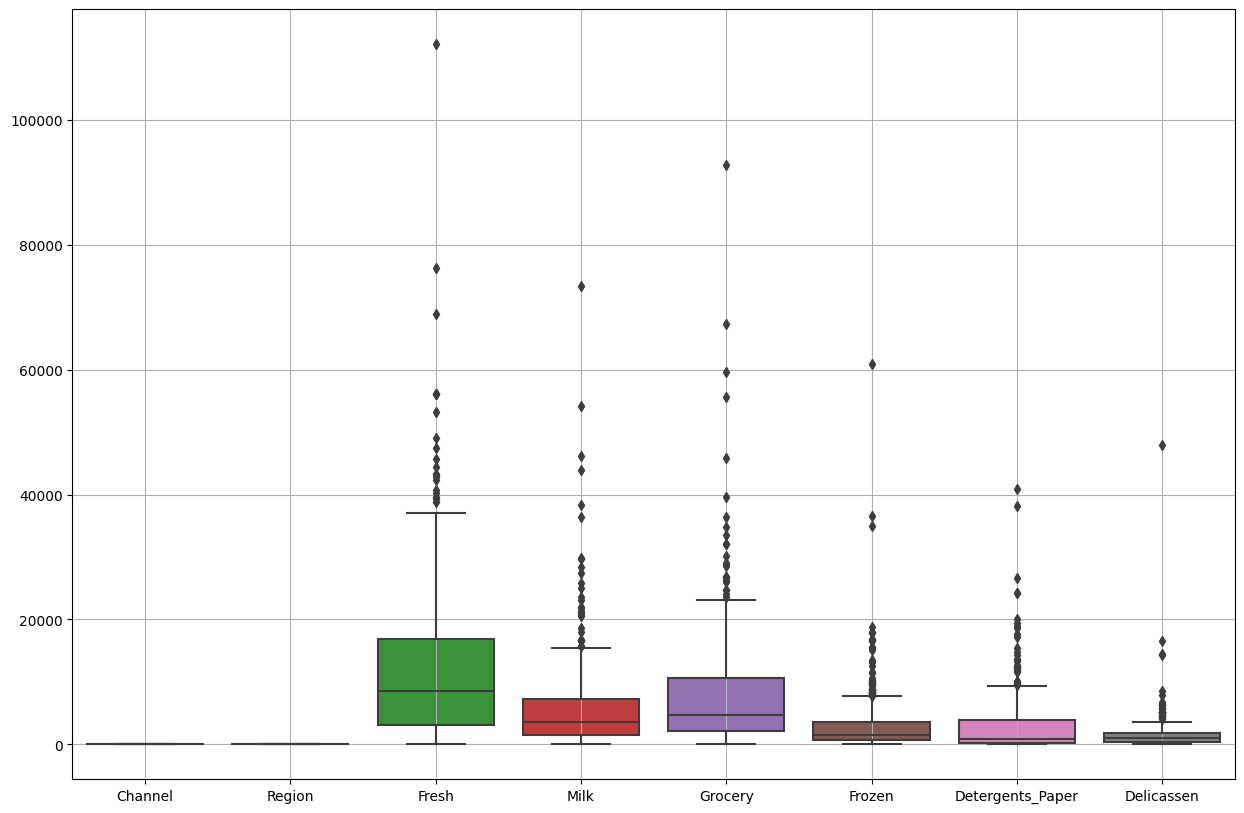

In [4]:
plt.figure(figsize=(15,10))
sns.boxplot(df)
plt.grid()

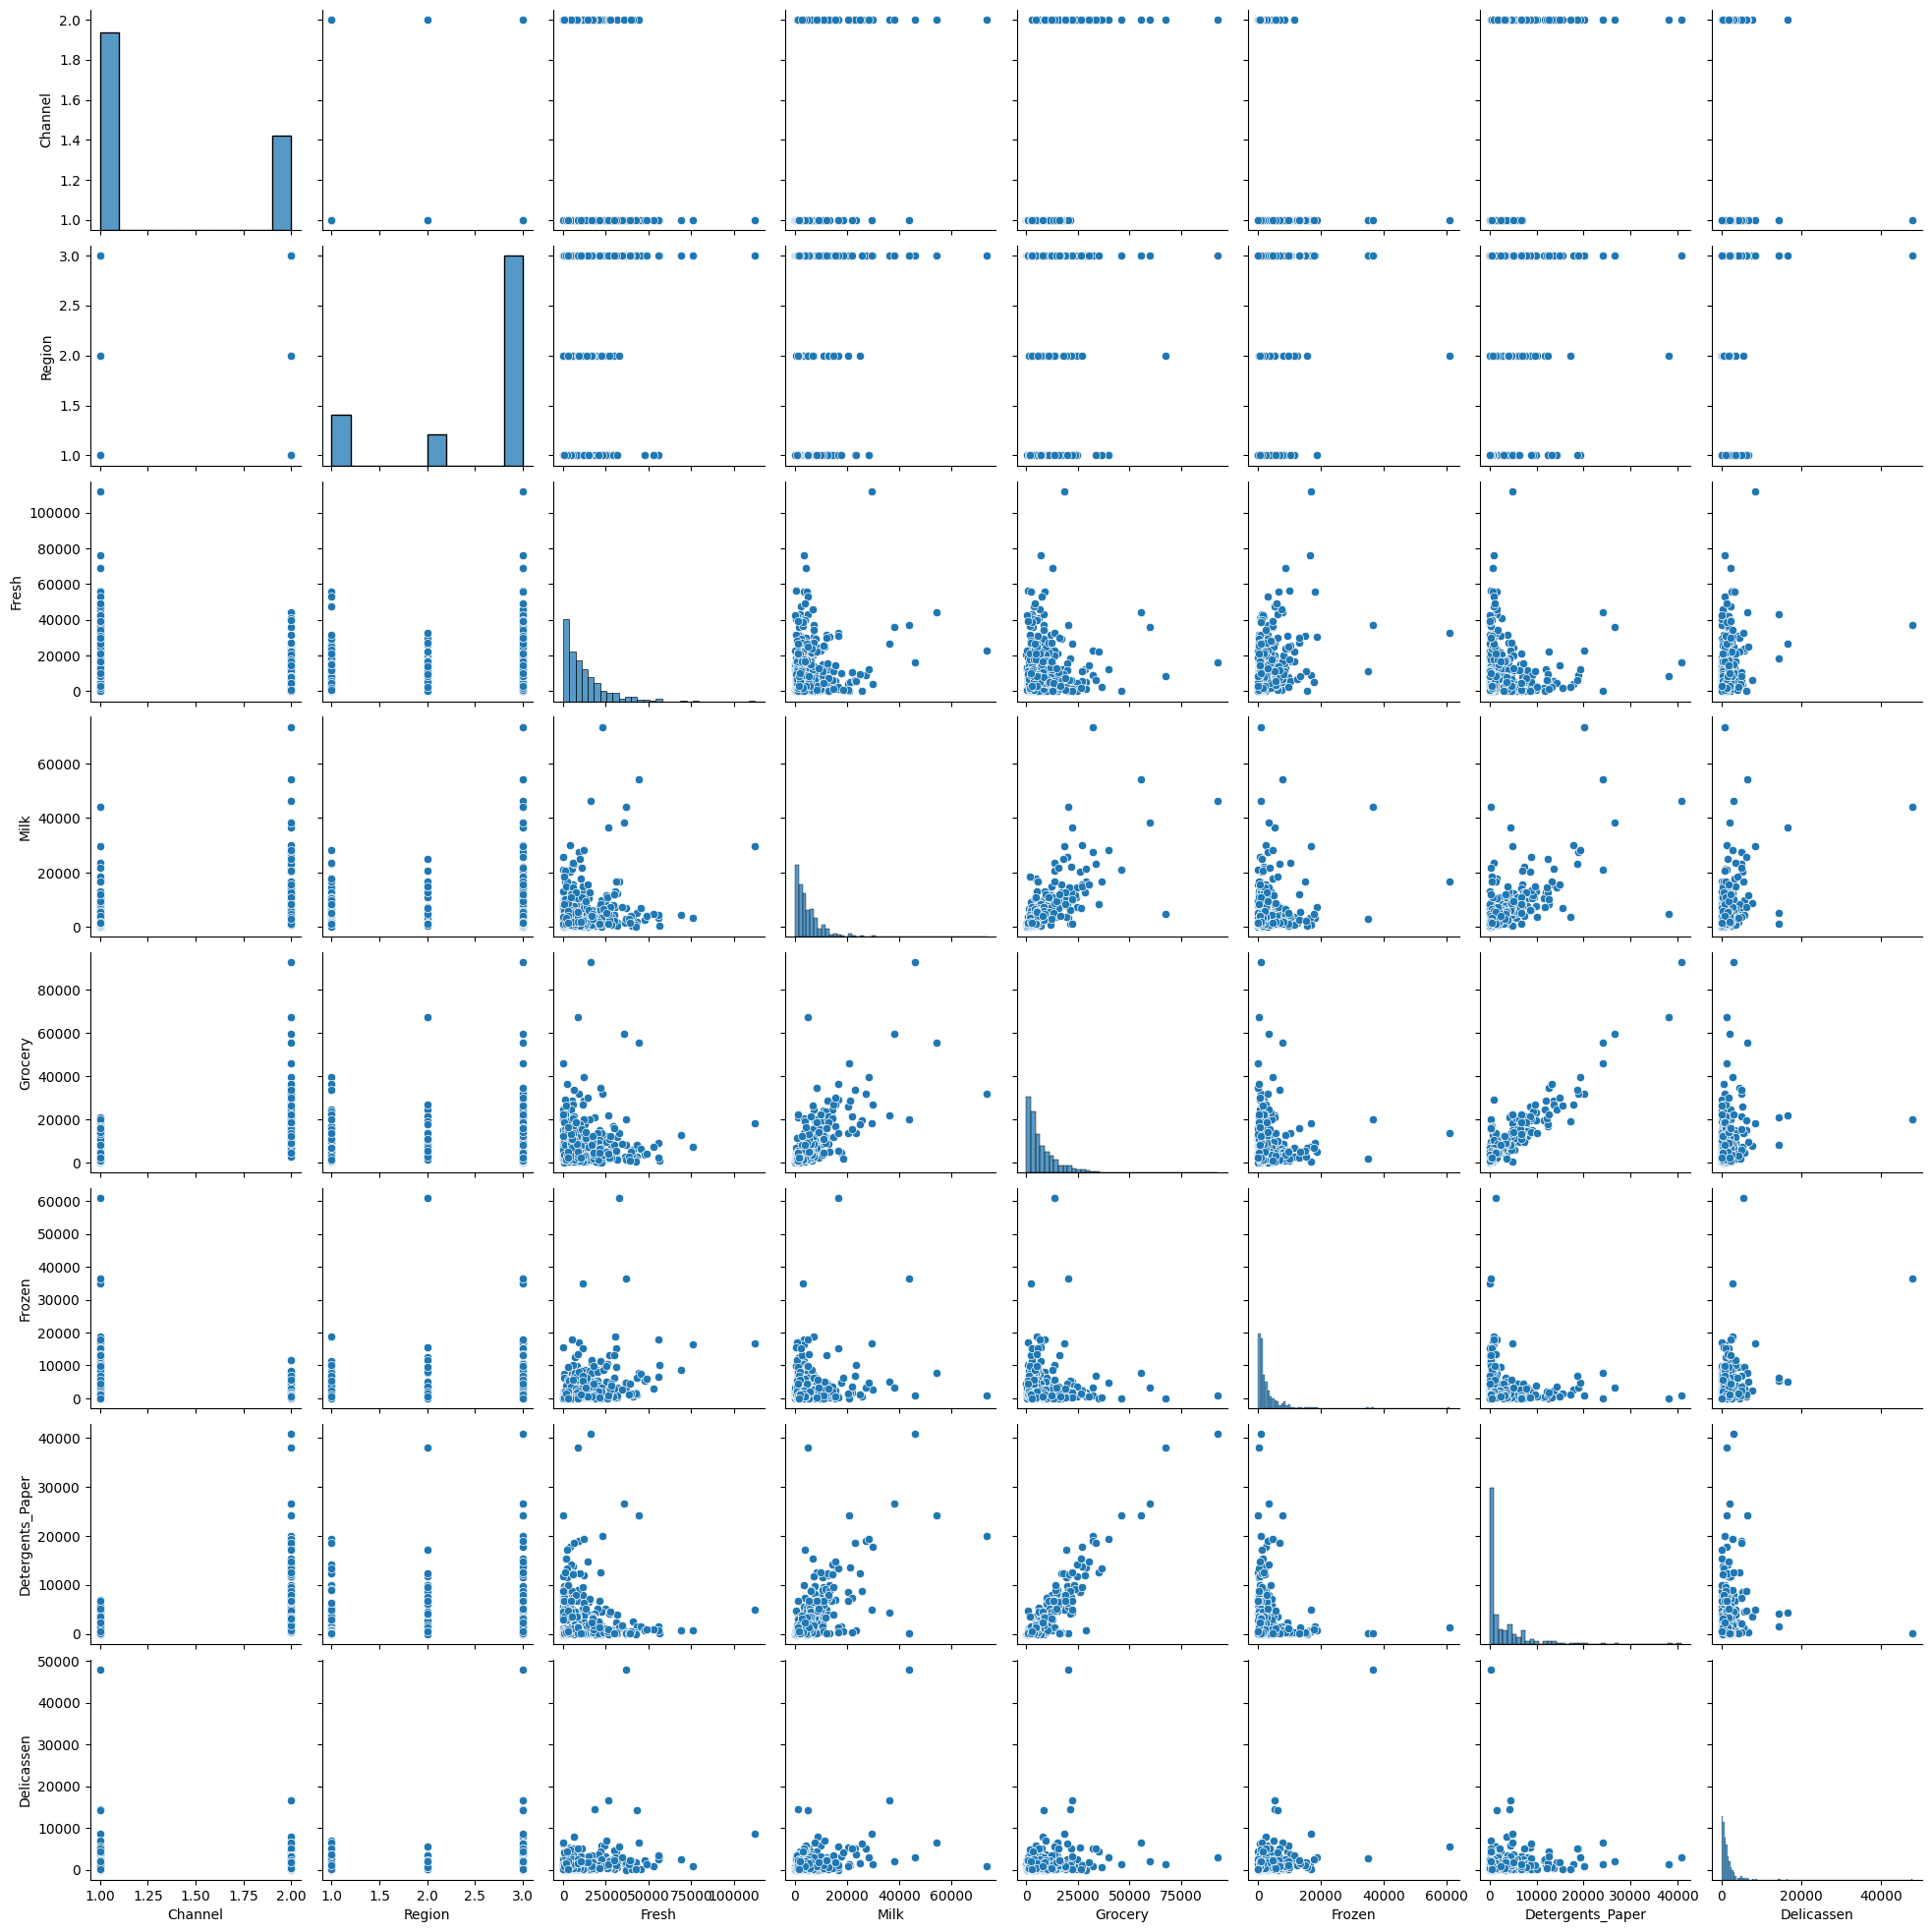

In [5]:
sns.pairplot(df)

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` computing the *square root*
1. remap all the variables in the range `0:1`

In [6]:
# square root transformation - the first two columns are not transformed
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
goods=["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
for good in goods:
    df[good] = df[good].apply(lambda x: sqrt(x))

# remap on the 0:1 range with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df=pd.DataFrame(scaler.fit_transform(df), columns=df.columns)




Show the result of the transformation

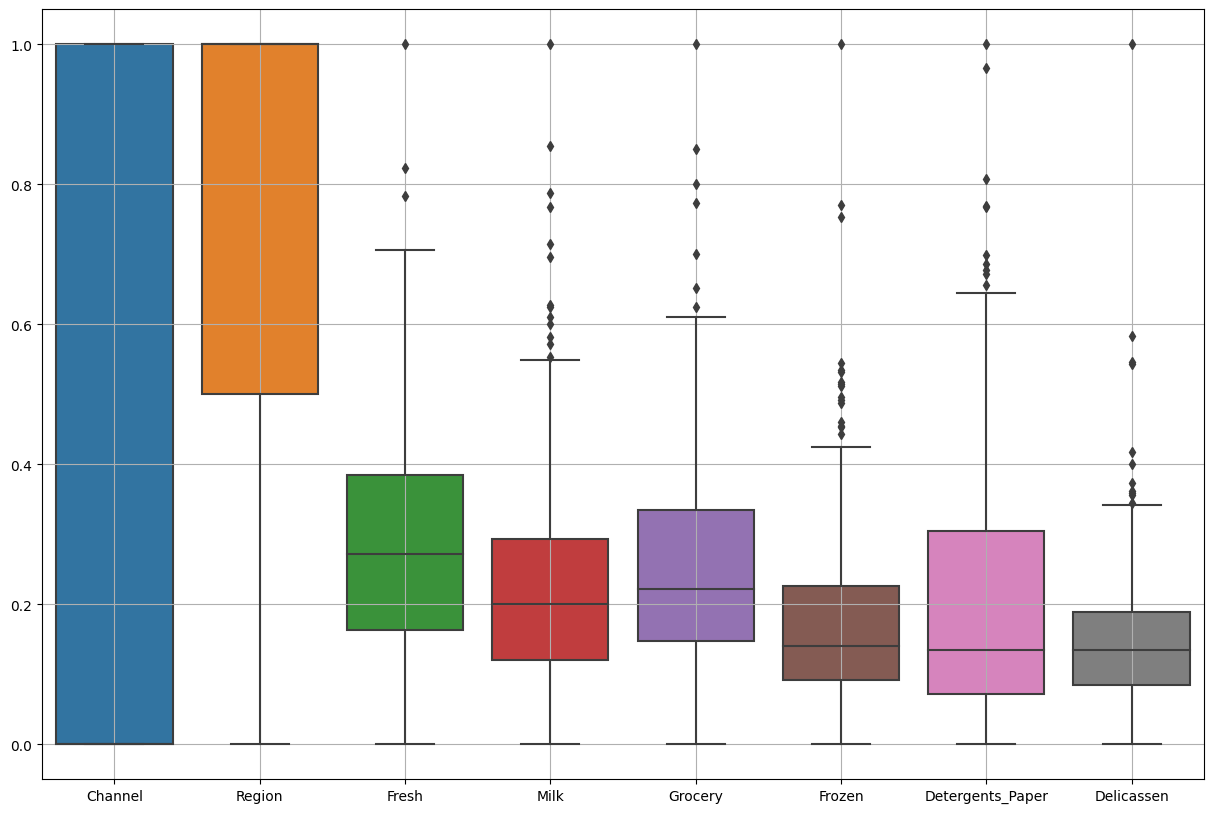

In [7]:
plt.figure(figsize=(15,10))
sns.boxplot(df)
plt.grid()

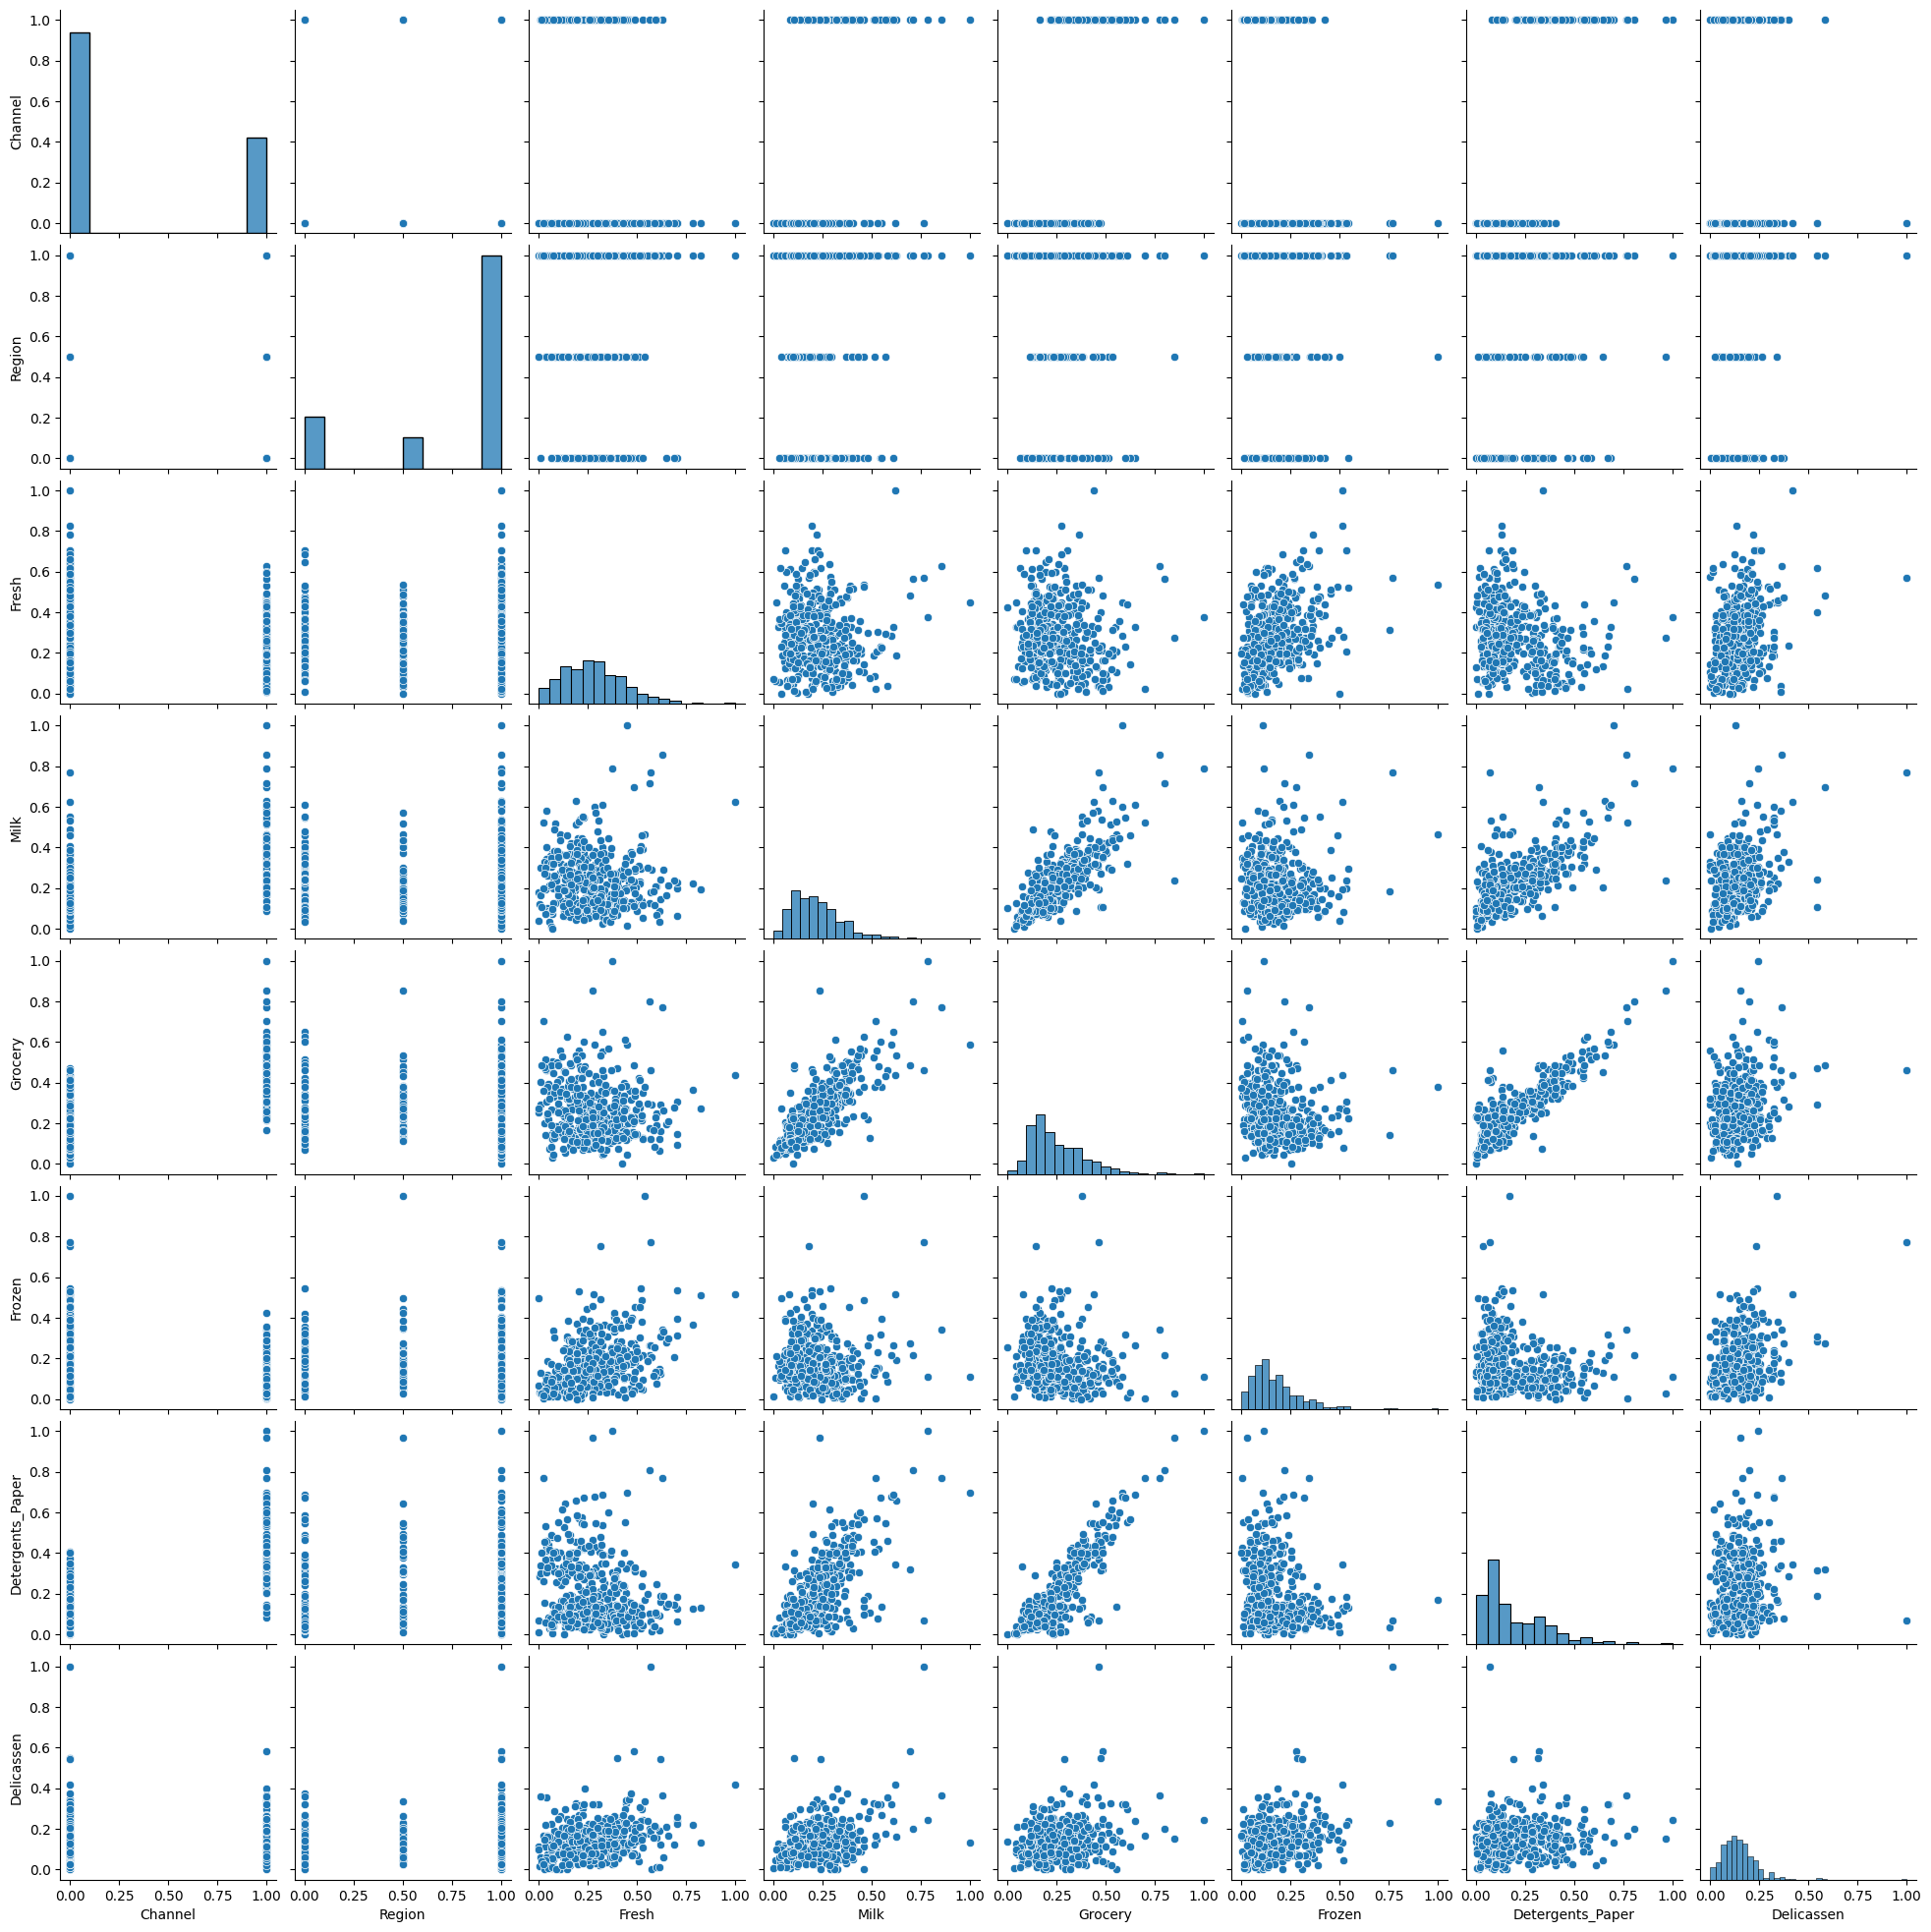

In [8]:
sns.pairplot(df)

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [9]:
from sklearn.model_selection import ParameterGrid
#parameter grid crea tutte le combinazioni di parametri possibili date dei dizionari di singoli parametri con ognuno diversi parametri da testare
#in questo caso però abbiamo solo un parametro (k) con 9 valori da testare

k_range = list(range(2,11)) # set the range of k values to test 
#create parameter grid
pg = [{'n_clusters': k_range}]
param_grid = list(ParameterGrid(pg))
print(param_grid)


[{'n_clusters': 2}, {'n_clusters': 3}, {'n_clusters': 4}, {'n_clusters': 5}, {'n_clusters': 6}, {'n_clusters': 7}, {'n_clusters': 8}, {'n_clusters': 9}, {'n_clusters': 10}]


In [10]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
inertia_km=[]
silhouette_km=[]
for param in param_grid:
    kmeans=KMeans(**param, random_state=random_state)
    y_km=kmeans.fit_predict(df)
    inertia_km.append(kmeans.inertia_)
    silhouette_km.append(silhouette_score(df, y_km))




## 4. Plot __inertia__ and __silhouette score__ versus `k`

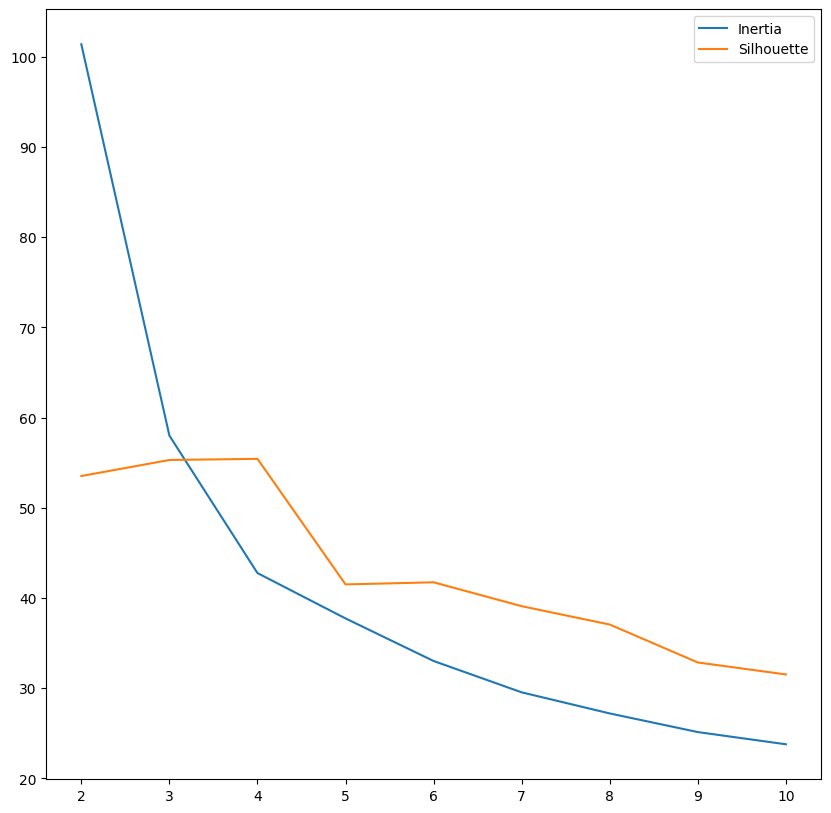

In [11]:
plt.figure(figsize=(10,10))
plt.plot(range(2,11), inertia_km, label="Inertia")
plt.plot(range(2,11), np.array(silhouette_km)*100, label="Silhouette")
plt.legend()


## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.<br>
**NOTE:** The higher the silhouette, the better.

We will choose k=3

In [12]:
k=3
kmeans=KMeans(n_clusters=k)
y_km=kmeans.fit_predict(df)

In [13]:
s=silhouette_score(df, y_km)
i=kmeans.inertia_
print("K:",k,"\tsilhouette:",s,"\t inertia:",i)

K: 3 	silhouette: 0.5529474186615309 	 inertia: 57.99859420311193


### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Agglomerative clustering
We will try a grid of parameter configurations, with the number of clusters in the range `2:10` and the four linkage methods available in the *sklearn* implementation of *AgglomerativeClustering*. 

In [34]:
from sklearn.cluster import AgglomerativeClustering
k_range = list(range(2,10)) # set the range of k values to test 
#create parameter grid
pg = [{'n_clusters': k_range,'linkage' : ['ward', 'complete', 'average', 'single']}]
param_grid = list(ParameterGrid(pg))
print(param_grid)

[{'linkage': 'ward', 'n_clusters': 2}, {'linkage': 'ward', 'n_clusters': 3}, {'linkage': 'ward', 'n_clusters': 4}, {'linkage': 'ward', 'n_clusters': 5}, {'linkage': 'ward', 'n_clusters': 6}, {'linkage': 'ward', 'n_clusters': 7}, {'linkage': 'ward', 'n_clusters': 8}, {'linkage': 'ward', 'n_clusters': 9}, {'linkage': 'complete', 'n_clusters': 2}, {'linkage': 'complete', 'n_clusters': 3}, {'linkage': 'complete', 'n_clusters': 4}, {'linkage': 'complete', 'n_clusters': 5}, {'linkage': 'complete', 'n_clusters': 6}, {'linkage': 'complete', 'n_clusters': 7}, {'linkage': 'complete', 'n_clusters': 8}, {'linkage': 'complete', 'n_clusters': 9}, {'linkage': 'average', 'n_clusters': 2}, {'linkage': 'average', 'n_clusters': 3}, {'linkage': 'average', 'n_clusters': 4}, {'linkage': 'average', 'n_clusters': 5}, {'linkage': 'average', 'n_clusters': 6}, {'linkage': 'average', 'n_clusters': 7}, {'linkage': 'average', 'n_clusters': 8}, {'linkage': 'average', 'n_clusters': 9}, {'linkage': 'single', 'n_cluste

In [36]:
inertia_a=[]
silhouette_a=[]
result={"n_clusters":[], "linkage":[], "silhouette_a":[]}
for param in param_grid:
    agg_clust=AgglomerativeClustering(**param)
    y_a=agg_clust.fit_predict(df)
    result["silhouette_a"].append(silhouette_score(df, y_a))
    result["n_clusters"].append(param["n_clusters"])
    result["linkage"].append(param["linkage"])

    


In [37]:
result_df=pd.DataFrame(result)
result_df.sort_values(by='silhouette_a', ascending=False).head(5)

,n_clusters,linkage,silhouette_a
20,6,average,0.555314
2,4,ward,0.553519
1,3,ward,0.552275
21,7,average,0.550038
22,8,average,0.545323


In [38]:
print(result_df.iloc[[1]])

   n_clusters linkage  silhouette_a
1           3    ward      0.552275


The top five results have a very similar silhouette score, we will choose the setting with 3 clusters, as for k-means, and the linkage giving the best result with 3 clustes, that is `ward`. This is the result record with `index 1` (the record index is the unnamed column at the very left of the dataframe output

In [39]:
ac=AgglomerativeClustering(n_clusters=3,linkage="ward")
y_ac=ac.fit_predict(df)


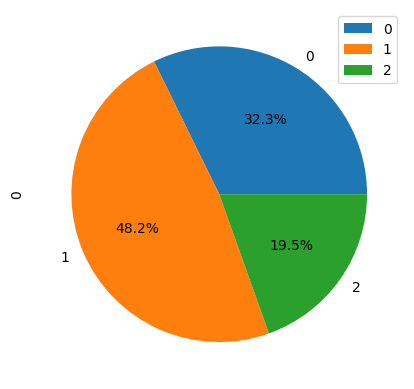

In [40]:
clust_sizes_ac = np.unique(y_ac,return_counts=True)
pd.DataFrame(clust_sizes_ac[1]).plot.pie(y=0, autopct='%1.1f%%', )
plt.show()

Show the distribution of data in the three clusters

### Comments


The solution with the Agglomerative Clustering in this case provides a result very similar to that of kmeans.

It is interesting to compare more deeply the results of the two clustering models. 

The function `pair_confusion_matrix` computes the number of pairs of objects that are in the same clusters or in different clusters in two different clustering schemes. 

The result is given in a 2x2 matrix, the perfect match is when only the numbers in the main diagonal are non zero.

We present here the results normalized to 1

In [41]:
from sklearn.metrics import pair_confusion_matrix
pcm = pair_confusion_matrix(y_km,y_ac)
pcm / pcm.sum()

array([[0.62603023, 0.00218472],
       [0.00089045, 0.3708946 ]])

In [42]:
print("The percentage of match between the two clustering schemes is {:6.2f}%"\
    .format((pcm / pcm.sum()).diagonal().sum()*100))

The percentage of match between the two clustering schemes is  99.69%


## Control questions
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results